# [Chapter 8] Cleaning the Ames housing data

## **[DSLC stages]**: Data cleaning and pre-processing



## Domain problem formulation



Our overall goal for this project is to develop a predictive algorithm that we can use to predict the sale price of houses in Ames, Iowa.



## Data source overview


The data we will use was collated in 2011 by Dean De Cock. The original paper discussing this data can be found [here](http://jse.amstat.org/v19n3/decock.pdf) as well as in the file `data/data_documentation/decock_ames_2011.pdf`. 

De Cock obtained this data directly from the Ames City Assessor's Office following a brief meeting with the Assessor and Deputy Assessor.  


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100



## Step 1: Review background information


### Information on data collection 


We don't know a whole lot about how the numbers in the data were collected, i.e. were all houses assessed by the same assessor(s)? Did the assessor collecting the information use a paper form, and then put the information into a spreadsheet or did the assessor collecting the information record it directly on a computer?

We do know that the data De Cock received contained several variables that were very specific to the Assessor's office uses, such as weighting and adjustment factors used in the city's modeling system, and that De Cock removed these variables. 

Note that an Assessor's office is *not* a real-estate office or sales office. The purpose of the assessor's office is "discovering changes in real property, such as new construction, and maintaining the classification and values for the entire tax base of Ames". To be eligible to be appointed an assessor in Iowa for a six-year term, one needs to pass a comprehensive examination. In order to be reappointed, "150 hours of state-approved continuing education, of which at least 90 hours must be
tested courses, are required during the six-year term". 

This information (and more) was found directly on the [City of Ames](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/reports) website. We saved the "Ames City Assessor's Budget Proposal for the 2022-2023 Fiscal Year" pdf document in the file `data/data_documentation/additional_assessor_information.pdf`. This document, while not of the same time period as the data we will be examining, gives a reasonable sense of what kind of duties the City Assessor's office performs and what kind of data they collect.


### Data dictionary


The data dictionary is provided in file `data/additional_info/DataDocumentation.txt`




The response variable for this project is the sale price (`SalePrice`) of each house. The `ORDER` and `PID` columns seem to correspond to row and house identifier columns. 

One thing that we notice is that there are a lot of related variables. 

One question that arises is whether the `Bsmt Unf Sf`, `BsmtFin SF 1`, and `BsmtFin SF 2`, all add up to `Total Bsmt SF`? If so, this may cause issues of collinearity when we try to fit our predictive algorithms unless we remove one of the variables (or remove all three of the sub-variables and just keep `Total Bsmt SF`).




::: {.blackbox data-latex=""}

**Question: do the `Bsmt Unf Sf`, `BsmtFin SF 1`, and `BsmtFin SF 2`, all add up to `Total Bsmt SF`**

Check whether the three basement square footage variables add up to the total basement square footage variable. If so, likely we will want to remove one of the `Bsmt Unf Sf`, `BsmtFin SF 1`, and `BsmtFin SF 2` variables, or remove all three if we want to actively simplify the data.
:::




Similarly, we are curious whether general square footage variables (`1st Flr SF`, `2nd Flr SF`, `Total Bsmt SF` and `Low Qual Fin SF`) add up to the `gr_liv_area` variable.


::: {.blackbox data-latex=""}

**Question: do any combination of the `1st Flr SF`, `2nd Flr SF`, `Total Bsmt SF` and `Low Qual Fin SF` add up to `Gr Liv Area`?**

Check whether any combination of the general square footage variables add up to the greater living area variables.  Again, if so, likely we will want to remove one of the `...SF` variables, or remove all three if we want to actively simplify the data.
:::





### Answering questions about the background information

In this section, we will go through the recommended background information questions from the Data Cleaning chapter.

- *What does each variable measure?* Most of the information in the data dictionary is fairly self-explanatory.

- *How was the data collected?* We don't know for sure, but if we are to picture the data collection process we *assume* that an appointed assessor visited each house and recorded the information on a form, and then later input this information into a database or spreadsheet. This is purely speculation, however, since we don't have enough information to be able to properly picture how the data was collected.

- *What are the observational units?* The observational units are the houses.

- *Is the data relevant to my project?* Actually, since we are interested in generating an algorithm to predict the sale price of houses for sale in our current time period, and this dataset spans the years 2006-2010, this data is actually likely *not* relevant to our project. We will explore this more below.




### Exploring data relevance using zillow data {#sec-zillow}

To explore whether the housing prices from 2006-2010 that is being reflected by this data bear any resemblance to housing prices more than a decade later, we turn to Zillow, which provides a large amount of [public real estate data](https://www.zillow.com/research/data/) (although not at the level of detail on each house that we got from De Cock's Ames Assessor data).

First let's load in the data that we downloaded from Zillow's website (we saved the file as `ames_zillow.csv`):


In [2]:
zillow_prices = pd.read_csv("../data/ames_zillow.csv")

In [3]:
zillow_prices.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,195870.0,195305.0,194996.0,194451.0,194267.0,194135.0,194062.0,193929.0,193887.0,193956.0,194111.0,194369.0,194757.0,195747.0,196795.0,197751.0,198208.0,198790.0,199481.0,200392.0,201308.0,202219.0,203381.0,204589.0,205874.0,206485.0,206990.0,207372.0,208172.0,209002.0,209785.0,210830.0,212014.0,213464.0,214663.0,215895.0,216961.0,218323.0,219769.0,221640.0,223637.0,225784.0,228273.0,230511.0,232775.0,234614.0,236392.0,238207.0,240181.0,242858.0,245906.0,248959.0,251811.0,254487.0,257196.0,259584.0,262090.0,264840.0,268072.0,270944.0,273680.0,276274.0,279761.0,283212.0,286299.0,288517.0,290607.0,292853.0,294893.0,297062.0,29


Next, we will filter to the relevant information:

In [4]:
zillow_prices_ames = zillow_prices.query("RegionName == 'Ames' & StateName == 'IA'") \
                                  .drop(columns=["RegionID", "SizeRank", "RegionName", "RegionType", 
                                                 "StateName", "State", "Metro", "CountyName"]) \
                                  .melt(var_name="date", value_name="price")
zillow_prices_ames["date"] = pd.to_datetime(zillow_prices_ames["date"])
zillow_prices_ames = zillow_prices_ames.query("date >= '2005-3-31'") \
                                       .reset_index(drop=True)
zillow_prices_ames

,date,price
0,2005-03-31,178072.0
1,2005-04-30,179125.0
2,2005-05-31,180328.0
3,2005-06-30,182410.0
4,2005-07-31,184142.0
...,...,...
178,2020-01-31,243644.0
179,2020-02-29,243731.0
180,2020-03-31,244016.0
181,2020-04-30,244169.0



Then we will create a line plot that shows the house price trends over time, with the time period covered by De Cock's Assessor's office data highlighted in grey.

In [5]:
fig = px.line(zillow_prices_ames, x="date", y="price")
fig.add_vrect(x0="2006-01-01", x1="2010-07-01", y0=0, y1=1,
              fillcolor="grey", opacity=0.25, line_width=0, layer="below")

/opt/homebrew/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


It is disturbingly clear that the sale prices during the time period that De Cock's data covers are *very* different to the sale prices a decade later. There is a general trend where house prices in Ames have grown immensely over the past decade, from an average of around \$190,000 in 2010, to an average of around \$240,000 in 2020. Any predictive algorithm that we build using data from 2006 to mid-2010 is going to vastly under-predict the sale price for houses today. 



Our problem now is that there doesn't exist a publicly available Ames housing dataset (that includes information on the features of the individual houses) for a broader data range. De Cock originally collected this data by getting in touch directly with the Ames City Assessor’s Office, and asking for permission to make the data public. Since we did not want to bother the Assessor's Office for this educational example, and we won't be applying whatever algorithm we create in real life, we will still use this dataset for demonstration purposes, but we will make a compromise: we're going to use our imagination and *pretend that we live in the year 2011* (the year after De Cock's dataset ends).



## Step 2: Loading the data

Fortunately the data consists of only one single file. But this file is a `.txt` file, rather than a `.csv` file, so we can't use our trusty `read_csv()` function. 

Instead, we will use the generic base R (i.e., non-tidyverse) `read.table()` function. This function requires us to specify how entries are separated from one another in the data. A quick look and experimentation implies that it is tab-separated (every entry in the data is separated by a tab).

In [6]:
# note that one column "Mas Vnr Type" has entries "None" which are not missing
# but if we don't specify na_values="" and keep_default_na=False it will treat "None" entries as NaN
ames_orig = pd.read_table("../data/AmesHousing.txt", sep="\t", header=0, 
                          na_values=["", "NA"], keep_default_na=False)


Let's look at the first few rows to make sure it looks like it has been loaded in correctly:


In [7]:
ames_orig.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900



And let's examine the dimension of the data.


In [8]:
ames_orig.shape

(2930, 82)


Everything seems to match what we expected from the data dictionary above (except the column names got a bit warped in the loading - they now have periods instead of spaces and variables that started with a number now have a preceding "X"). 






### Filtering to the relevant portion of the data


Since we are only interested in *houses* sold in so-called "normal" sales (i.e., we don't want to include foreclosures, within-family sales, sales of incomplete homes, etc), we will filter the data to just include such sales. We will also exclude agricultural, commercial, and industrial sales.

Note that now we are editing the data, we create a new object `ames` so that we still have a copy of the originally loaded dataset in our environment (`ames_orig`).




In [9]:
ames = ames_orig.copy()
ames = ames.query("(`Sale Condition` == 'Normal') & (`MS Zoning` != ['A (agr)', 'C (all)', 'I (all)'])")


While we could apply whatever data cleaning function we write below to this pre-filtered version of the data, it will be helpful to instead write a function that, if applied to the original (unfiltered) version of the data will do this filtering step too. Thus we will note down a data loading action item to include in our cleaning/pre-processing function.

> **Data loading action item: filter to "normal" sales and zones only**
> 
> Ensure that the data only contains `Sale Condition == "Normal"` and `MS Zoning` is not equal to any of `"A (agr)", "C (all)", "I (all)"`



## Step 3: Examine the data

In this section we explore the common messy data traits to identify any cleaning action items.



### Finding invalid values


Following the suggested explorations for identifying invalid values, we will first look at randomly selected rows of the data to get a sense for what the values in each column look like. 


In [10]:
ames.sample(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
296,297,909428280,20,RL,100.0,17500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,PosA,Norm,1Fam,1Story,7,8,1959,2002,Gable,CompShg,BrkFace,HdBoard,None,0.0,Gd,Gd,PConc,Gd,TA,Av,GLQ,1406.0,Unf,0.0,496.0,1902.0,GasA,TA,Y,SBrkr,1902,0,0,1902,1.0,0.0,2,0,3,1,Ex,7,Typ,2,TA,Attchd,1959.0,Fin,2.0,567.0,TA,TA,Y,0,207,162,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,335000
2691,2692,903452090,70,RM,60.0,7518,Pave,NaN,Reg,Lvl,AllPub,FR3,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,8,1910,2004,Gable,CompShg,AsbShng,Plywood,None,0.0,Fa,Gd,BrkTil,Fa,Fa,No,Unf,0.0,Unf,0.0,396.0,396.0,GasA,Gd,Y,SBrkr,665,665,0,1330,0.0,0.0,1,0,3,1,TA,7,Typ,0,NaN,Detchd,2001.0,Unf,1.0,390.0,TA,TA,N,0,72,45,0,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,116500
1833,1834,533130170,50,RL,85.0,10678,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1.5Fin,8,5,1992,2000,Hip,CompShg,HdBoard,HdBoard,BrkFace,337.0,Gd,TA,PConc,Gd,TA,No,GLQ,700.0,Unf,0.0,983.0,1683.0,GasA,Ex,Y,SBrkr,2129,743,0,2872,0.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,1992.0,Fin,2.0,541.0,TA,TA,Y,0,33,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,285000
1567,1568,914476010,20,RL,75.0,10125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,641.0,LwQ,279.0,276.0,1196.0,GasA,TA,Y,SBrkr,1279,0,0,1279,0.0,1.0,2,0,3,1,TA,6,Typ,2,Fa,Detchd,1980.0,Unf,2.0,473.0,TA,TA,Y,238,83,0,0,0,0,NaN,MnPrv,NaN,0,2,2008,WD,Normal,171500
1201,1202,534251280,60,RL,NaN,9130,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Feedr,Norm,1Fam,2Story,6,8,1966,2000,Hip,CompShg,HdBoard,HdBoard,BrkFace,252.0,TA,TA,CBlock,TA,TA,No,GLQ,400.0,Rec,64.0,336.0,800.0,GasA,Gd,Y,SBrkr,800,832,0,1632,0.0,1.0,1,1,4,1,Gd,7,Typ,0,NaN,Attchd,1966.0,Unf,2.0,484.0,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,173000
1666,1667,527404050,20,RL,66.0,7920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1970,2002,Gable,CompShg,HdBoard,HdBoard,BrkFace,32.0,TA,TA,CBlock,TA,TA,No,ALQ,81.0,GLQ,619.0,214.0,914.0,GasA,Ex,Y,SBrkr,914,0,0,914,0.0,0.0,1,0,3,1,Ex,5,Typ,0,NaN,Attchd,1970.0,RFn,1.0,368.0,TA,Gd,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,WD,Normal,133000
2825,2826,908186060,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,5,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,80.0,TA,TA,PConc,Gd,TA,Gd,GLQ,547.0,Unf,0.0,0.0,547.0,GasA,Gd,Y,SBrkr,1072,0,0,1072,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Basment,2005.0,Fin,2.0,525.0,TA,TA,Y,0,28,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000
2745,2746,905480160,50,RL,50.0,7585,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,1.5Fin,5,3,1948,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Fa,Fa,Mn,Unf,0.0,Unf,0.0,810.0,810.0,GasA,Fa,Y,FuseA,1002,454,0,1456,1.0,1.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1954.0,Unf,1.0,280.0,TA,TA,P,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal,91500
2523,2524,534125210,190,RL,79.0,13110,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,RRAn,Feedr,2fmCon,1Story,5,6,1972,1972,Gable,CompShg,Plywood,Plywood,BrkFace,144.0,TA,TA,CBlock,Gd,TA,No,GLQ,962.0,


#### Numeric variables


To explore the validity of the values in the numeric variables, we will first look at the min, max, and mean for each column.

In [11]:
ames.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2397.000000,2.397000e+03,2397.000000,1948.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2386.000000,2397.00000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2396.000000,2396.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2284.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000,2397.000000
mean,1418.370880,7.167764e+08,57.934919,68.181211,10037.710054,6.023363,5.653734,1969.789320,1983.408010,96.725901,441.08761,55.492699,529.141844,1025.722153,1135.498540,339.218189,4.339174,1479.055903,0.433639,0.062187,1.541510,0.379224,2.856487,1.039633,6.369629,0.606174,1976.459282,1.737171,462.487276,96.400501,44.817272,23.151856,2.476429,16.358365,1.788903,51.587401,6.114727,2007.870672,176172.005841
std,842.337625,1.885971e+08,42.845268,22.649368,8174.657434,1.325664,1.119079,29.244141,20.247312,172.907853,416.62146,177.818549,417.824716,407.804595,366.376529,423.648096,45.145014,482.744331,0.514690,0.243268,0.544789,0.498866,0.812730,0.199368,1.519285,0.649331,24.168242,0.725294,200.308832,130.467596,63.057119,64.391134,25.256199,57.244924,31.473093,516.268793,2.628616,1.309702,70797.189813
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.00000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35000.000000
25%,686.000000,5.313850e+08,20.000000,57.000000,7399.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.00000,0.000000,210.000000,784.000000,868.000000,0.000000,0.000000,1104.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,130000.000000
50%,1389.000000,5.354571e+08,50.000000,68.000000,9373.000000,6.000000,5.000000,1971.000000,1991.000000,0.000000,388.00000,0.000000,439.000000,972.000000,1062.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,472.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,159000.000000
75%,2134.000000,9.071870e+08,70.000000,80.000000,11404.000000,7.000000,6.000000,1998.000000,2002.000000,150.000000,724.00000,0.000000,777.000000,1248.000000,1353.000000,704.000000,0.000000,1724.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,1999.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2009.000000,207000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2288.00000,1526.000000,2336.000000,3206.000000,3820.000000,1872.000000,1064.000000,4316.000000,2.000000,2.000000,4.000000,2.000000,6.000000,3.000000,13.000000,4.000000,2009.000000,5.000000,1488.000000,1424.000000,570.000000,1012.000000,508.000000,576.000000,800.000000,15500.000000,12.000000,2010.000000,755000.000000



Since it can be hard to tell if the maximums and minimums are reasonable, it is often helpful to visualize the distribution of each numeric variable using a histogram:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future vers

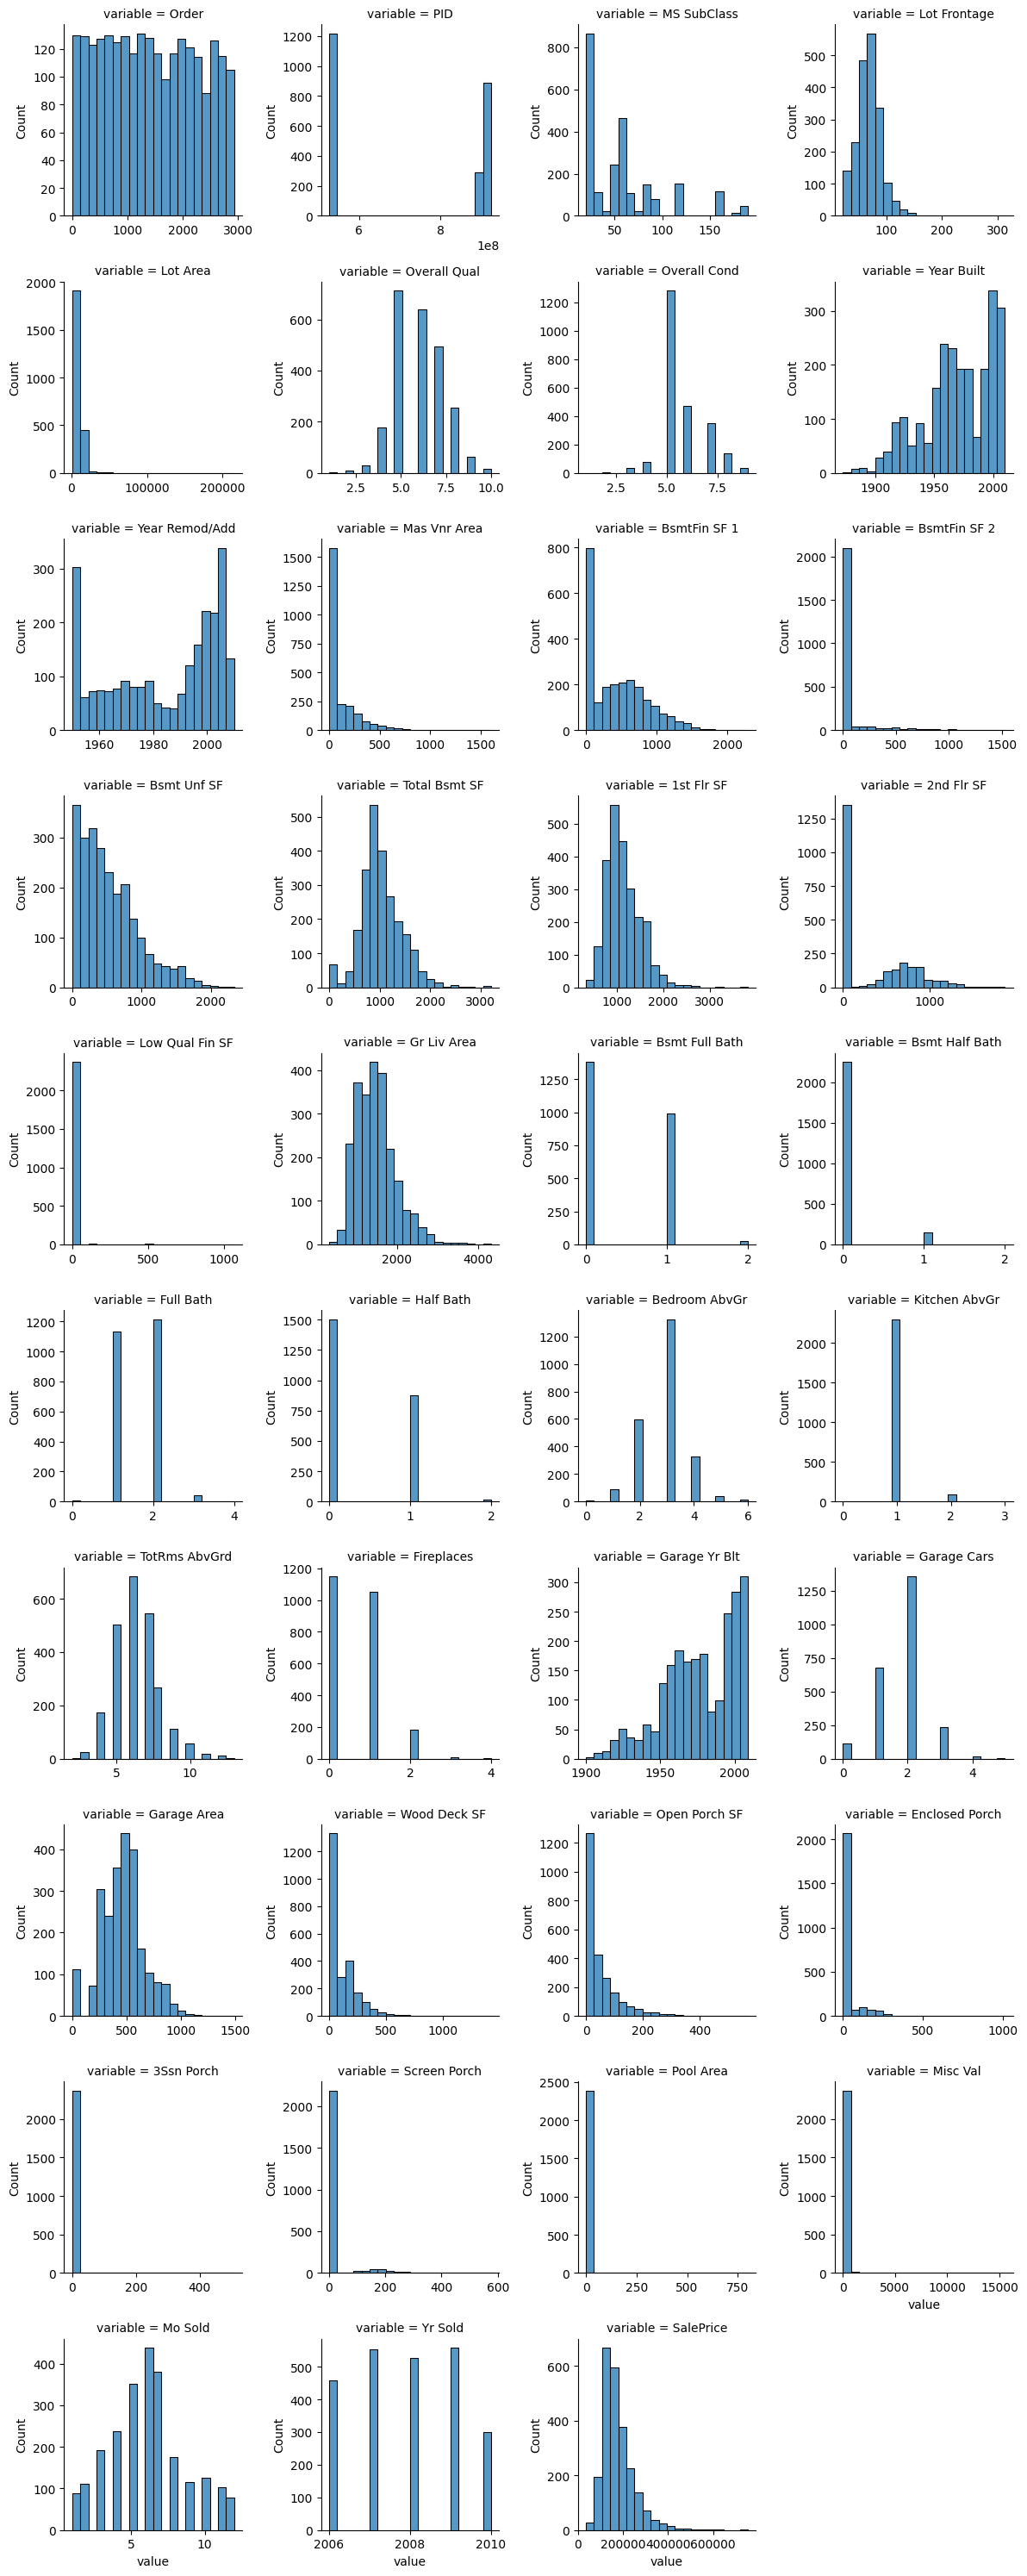

In [12]:
ames_numeric_long = ames.select_dtypes(include=np.number).melt()
g = sns.FacetGrid(ames_numeric_long, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=20)



When the x-axis range of a histogram appears to be much wider than the data (e.g., every value seems to be 0, but the range goes up to 600), this sometimes means that there are some very large values that are atypical. We see this for quite a few of the variables, such as `Misc Val`, `Low Qual Fin SF`, `Scree Porch`, etc.

While such atypically large entries are not necessarily in error, their presence should warrant further exploration. Let's look at some of these variables by investigating ordering the values from largest to smallest:

A quick look at the 250 largest values for `Screen Porch` shows us that, while there are only 200 or so non-zero values (out of more than 2,000), they don't look particularly unusual (they might look unusual look off if all of them were `9999`, for example, or if one was aggressively larger than the rest).

In [13]:
ames["Screen Porch"].sort_values(ascending=False).head(250)

1410    576
387     490
1288    480
2350    440
2666    410
       ... 
1937      0
1891      0
1924      0
1902      0
1909      0
Name: Screen Porch, Length: 250, dtype: int64

In [14]:
(ames["Screen Porch"] > 0).value_counts()

Screen Porch
False    2186
True      211
Name: count, dtype: int64

Similarly, a look at the largest values for `Low Qual Fin SF` shows that there are only 30 or so non-zero values, rendering this variable fairly uninformative to begin with. The non-zero values themselves don't necessarily look odd.

In [15]:
ames["Low Qual Fin SF"].sort_values(ascending=False).head(100)

660     1064
1361     697
2666     572
2040     528
2852     514
1944     512
2842     481
2045     479
1529     473
1517     420
909      397
177      390
1524     384
238      362
755      360
2675     360
940      312
777      259
2696     234
675      232
1318     205
2241     205
1329     156
655      144
2730     140
723      120
1291     108
2508      80
2507      80
2506      80
2337      53
1929       0
1900       0
1941       0
1898       0
1899       0
1901       0
1942       0
1902       0
1940       0
1903       0
1939       0
1938       0
1904       0
1897       0
1895       0
1896       0
1906       0
1894       0
1943       0
1893       0
1892       0
1891       0
1946       0
1890       0
1889       0
1888       0
1887       0
1886       0
1885       0
1905       0
1937       0
1907       0
1918       0
1930       0
1931       0
1927       0
1926       0
1925       0
1924       0
1932       0
1923       0
1922       0
1921       0
1920       0
1919       0
1884       0

In [16]:
(ames["Low Qual Fin SF"] > 0).value_counts()

Low Qual Fin SF
False    2366
True       31
Name: count, dtype: int64


We find similar things for the other variables too.

One variable that does look a little bit strange is `Year Remod/Add`. Notice that there is a strange peak at 1950:


In [17]:
px.histogram(ames, x="Year Remod/Add")

In [18]:
ames.value_counts("Year Remod/Add", sort=False).head(10)

Year Remod/Add
1950    282
1951     10
1952     11
1953     18
1954     22
1955     22
1956     27
1957     19
1958     27
1959     28
Name: count, dtype: int64


Since there are many houses built before 1950, our best guess is that a value of 1950 either means that no remodel was added, or it was added before 1950 before good records were kept.


Another thought that comes to mind is that it is unlikely that every house had a remodel. Let's compare the `Year Built` variable with the `Year Remod/Add` variable in the scatterplot below:

In [19]:
px.scatter(ames, x="Year Built", y="Year Remod/Add", opacity=0.5)



From the figure, we fortunately see that there were no remodels added *before* the houses were built, and it seems fairly reasonable to assume that most of the remodels listed as 1950 are "fake". It might make sense to replace the `Year Remod/Add` values of 1950 with the corresponding house's `Year Built` value.

Let's see how many of the non-1950s remodel houses has their `Year Remod/Add` value equal to their `Year Built` value:

In [20]:
ames_compare_remodel_year = ames.copy()
ames_compare_remodel_year["year_remod_equal_built"] = ames_compare_remodel_year["Year Remod/Add"] == ames_compare_remodel_year["Year Built"]
ames_compare_remodel_year.query("`Year Remod/Add` > 1950").value_counts("year_remod_equal_built")

year_remod_equal_built
True     1283
False     832
Name: count, dtype: int64


Since the vast majority of the post-1950 `Year Remod/Add` values are indeed equal to the `Year Built` value, we will make an action item to replace the `Year Remod/Add` values equal to 1950 with the corresponding `Year Built` value. 



> **Data cleaning action item: Replace `Year.Remod.Add` values of 1950 with the corresponding `Year.Built` value**
>
> Since it seems that there is a reporting error that reports all houses built prior to 1950 as having had a remodel in 1950 (likely since there are no *reports* of remodels added prior to 1950), we will replace the `Year.Remod.Add` values of 1950 with the corresponding `Year.Built` value.



#### Categorical variables

Lastly, we will look at the unique values of each categorical value. The following code prints out the unique values for each variable as a list. 


In [21]:
ames.select_dtypes(include="object").apply(lambda col: col.value_counts(dropna=False), result_type="reduce")


MS Zoning                                                                                                                                                                                                                                                                                                                                                                                                    MS Zoning
RL    1891
RM     394
FV      92
RH      20
Name: count, dtype: int64
Street                                                                                                                                                                                                                                                                                                                                                                                                                            Street
Pave    2392
Grvl       5
Name: count, dtype: int64
Alley                                         


A few variables, such as `Mas Vnr Type`, `Bsmt Exposure`, `Garage Finish`, etc have a value that is `NaN`. Let's take a closer look at how often these values occur. According to the following tables counting the number of time each unique variable appears for each variable explored below, it seems that these blank entries are uncommon overall. 

In [22]:
ames["Mas Vnr Type"].value_counts(dropna=False)

Mas Vnr Type
None       1465
BrkFace     750
Stone       153
BrkCmn       18
NaN          11
Name: count, dtype: int64

In [23]:
ames["Bsmt Exposure"].value_counts(dropna=False)

Bsmt Exposure
No     1599
Av      315
Gd      219
Mn      197
NaN      67
Name: count, dtype: int64

In [24]:
ames["Garage Finish"].value_counts(dropna=False)

Garage Finish
Unf    1055
RFn     670
Fin     559
NaN     113
Name: count, dtype: int64


It also seems that there are several variables that take on one particular value most of the time (and are thus quite uninformative). While these variables are not technically an issue for data *cleaning* (their presence doesn't technically make the data "messy"), we may want to address them in pre-processing by removing all variables whose number of identical values are above some threshold.


> **Pre-processing action item: Remove variables with a large number of identical values**
> 
> Since some variables are uninformative and have almost the same value for every house (e.g., 0 for numeric variables), as a pre-processing step, we may want to remove all variables whose proportion of identical values are above a certain threshold, such as 80%. The reason we may want to remove these variables is that their presence can cause issues in our predictive analyses down the line (least squares is known to become unstable when there are such variables present in the data).
>
> Note that the choice of threshold will be a **judgment call** and will thus be implemented as an argument in the pre-processing function.



### Examining missing values


Let's count the proportion of missing (`NaN`) values in each column. There are a few features that have quite a lot of missing values (recall that there are 2397 rows in the data)

In [25]:
ames.apply(lambda col: col.isna().sum()).sort_values(ascending=False)

Pool QC            2388
Misc Feature       2302
Alley              2245
Fence              1896
Fireplace Qu       1150
Lot Frontage        449
Garage Yr Blt       113
Garage Qual         113
Garage Cond         113
Garage Finish       113
Garage Type         112
Bsmt Exposure        67
BsmtFin Type 2       66
Bsmt Qual            65
BsmtFin Type 1       65
Bsmt Cond            65
Mas Vnr Area         11
Mas Vnr Type         11
Bsmt Half Bath        1
Bsmt Full Bath        1
Electrical            1
Functional            0
Half Bath             0
Full Bath             0
TotRms AbvGrd         0
Fireplaces            0
Kitchen AbvGr         0
Bedroom AbvGr         0
Kitchen Qual          0
Order                 0
Low Qual Fin SF       0
Garage Cars           0
Garage Area           0
Paved Drive           0
Wood Deck SF          0
Open Porch SF         0
Enclosed Porch        0
3Ssn Porch            0
Screen Porch          0
Pool Area             0
Misc Val              0
Mo Sold         


There are several variables with almost all of their values missing, specifically `Pool QC`, `Misc Feature`, and `Alley` each have more than 90% of their values missing, and `Fence` has almost 80% of its values missing, with 17 other variables having fewer numbers of missing values.

Note that there are the same proportion of missing values for each of the `Garage` variables, and for the `Bsmt` variables. 

If you actually read through the data documentation, you would have noticed that there are some situations where a value of `NaN` is explicitly defined. For example, for the `Bsmt` variables, the data documentation explicitly says that `NaN` means "No Basement", and for the `Garage` variables, it says that `NaN` means "No Garage". Assuming that this is correct, this is very helpful information when it comes to deciding how to handle these missing values, and similarly for the `Pool QC`, `Alley`, and `Fence` variables.

Recall that, while missing values do not technically make a dataset messy, for our downstream analyses, we will need to pre-process the data prior to applying least squares (or other predictive algorithms) by removing the missing values, either by removing the rows entirely (not recommended unless these rows contain primarily missing data or are missing information in particularly important variables) or by imputing them with a reasonable non-missing value. Since we have information about what these missing values are intended to represent, we can conduct a domain-informed imputation approach for each missing value. 

We are going to argue that since a missing `Garage Qual`, `Garage Cond`, etc value or `Bsmt Qual`, `Bsmt Cond`, etc value corresponds to "no" garage or basement, that the quality and condition score of a nonexistent garage or basement should be 0 (i.e., lower than all houses that do have a garage or basement).


For the categorical variables, such as `Garage Finish` and `BsmtFin Type 1`, it would make sense to make a new category that is "no garage", "no basement", etc.

However, you might argue that not having a garage or basement is not as bad as having a really poor quality garage or basement, and thus that it makes more sense to impute the missing values with a "typical" score, such as the most common value. The decision will be a judgment call, as well will incorporate this judgment call into our pre-processing function that we write later in this document. 

One exception to this is the `Garage Yr Blt` (the year the garage was built) variable. Neither 0 nor a "typical" value will be the most sensible way to impute missing values in this variable, but rather the most sensible value to impute with (in our opinion) is going to be the year the *house* was built (`Year Built`).

In terms of the variables that have ~80%+ missing values, we will remove them


> **Pre-processing action item: Impute variables with fewer than 50% missing values**
>
> We will use domain knowledge to impute the missing values for the following variables: `Fireplace Qu`, `Lot Frontage`, `Garage Yr Blt`, `Garage Finish`, `Garage Qual`, `Garage Cond`, `Garage Type`, `Bsmt Exposure`, `BsmtFin Type 2`, `Bsmt Qual`, `Bsmt Cond`, `BsmtFin Type 1`, `Mas Vnr Type`, `Mas Vnr Area`, `Electrical`, `Bsmt Full Bath`, `Bsmt Half Bath`.
>
> The possible imputation methods include replacing the missing values with either 0 or the mean/median value for numeric variables, and for categorical variables, they include creating a new category for missing values or replacing missing values with the most common or "typical" category.
>
> The choice of imputation method is a **judgment call** and will thus be implemented as an argument in the pre-processing function.
>
> There is one exception: since imputing missing values for `Garage Yr Blt` with 0 will imply that these garages are much, much, much older than the rest, and imputing with a "typical" (e.g, mean) value seems less reasonable than just imputing with the year the house was built, we will impute `Garage Yr Blt` with the `Year Built` variable.



> **Pre-processing action item: Remove variables with more than 50% missing values**
>
> Since some variables are uninformative and have almost the same value for every house (e.g., 0 for numeric variables), as a pre-processing step, we may want to remove all variables whose proportion of missing values are above a certain threshold, such as 50%.
>
> Note that the choice of threshold will be a **judgment call**.





### Examining the data format


The data is already in a "tidy" format (as opposed to a "long" format or other format), where each row corresponds to the data for a single observational unit, and each column corresponds to a unique type of measurement. 



### Assessing column names

The column names need to be cleaned in order to conform to our tidy column name requirements of words in column names being underscore-separated and lowercase.

While there are some variables that it would be nice to manually rename to be more "human" readable, whenever there are more than 20 or so variables, this can be come tedious to do manually, and so we will just clean the current column names (rather than coming up with entirely new names). This will be implemented in the `clean_ames_data()` function that we will write in Step 4. 


> **Data cleaning action item: Clean the column names**
>
> Rename the columns so that they are consistently formatted, with underscore-separated words and human readable.




### Assessing variable type

The code below prints the type/class of each variable, each of which seems to be a string or an integer.

In [26]:
ames.dtypes.sort_values()

Order                int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
TotRms AbvGrd        int64
1st Flr SF           int64
Fireplaces           int64
Open Porch SF        int64
Enclosed Porch       int64
3Ssn Porch           int64
Screen Porch         int64
Pool Area            int64
Misc Val             int64
Mo Sold              int64
Yr Sold              int64
Wood Deck SF         int64
Year Remod/Add       int64
SalePrice            int64
PID                  int64
MS SubClass          int64
Overall Qual         int64
Year Built           int64
Overall Cond         int64
Lot Area             int64
Bsmt Unf SF        float64
Total Bsmt SF      float64
BsmtFin SF 2       float64
Garage Area        float64
BsmtFin SF 1       float64
Garage Cars        float64
Lot Frontage       float64
Bsmt Half Bath     float64
Mas Vnr Area       float64
G


Notice that the month (`Mo Sold`) and year (`Yr Sold`) variables are integer/numeric variables. This is fine, but it is going to be a lot more useful to have a properly formatted date variable, which we will need to conduct our train/val/test split below. So we will add an action item.



> **Data cleaning action item: Create a month-year 'date' variable that is properly formatted as a date**
>
> Combine the `Mo Sold` and `Yr Sold` variables to create a `date` variable that is correctly formatted as a date.




### Evaluating data completeness

Since we don't have a list of all houses sold in Ames during the data period, we don't know if the data contains all of the houses, but we feel confident in assuming that it does.



### Answering any unanswered questions

Throughout our exploration, we asked a question that we have not yet answered: do the `Bsmt Unf Sf`, `BsmtFin SF 1`, and `BsmtFin SF 2`, all add up to `Total Bsmt SF`?

Let's check whether or not this is the case (it certainly looks like it!):


In [27]:
ames_bsmt = ames.copy()
ames_bsmt["sum"] = ames_bsmt["Bsmt Unf SF"] + ames_bsmt["BsmtFin SF 1"] + ames_bsmt["BsmtFin SF 2"]
ames_bsmt[["Total Bsmt SF", "sum"]].sample(10)

,Total Bsmt SF,sum
2081,0.0,0.0
1863,912.0,912.0
358,707.0,707.0
2395,1896.0,1896.0
2254,970.0,970.0
2311,964.0,964.0
2227,1004.0,1004.0
1141,1408.0,1408.0
2540,825.0,825.0
1591,1189.0,1189.0


In [28]:
(ames_bsmt["Total Bsmt SF"] == ames_bsmt["sum"]).value_counts()

True    2397
Name: count, dtype: int64


We don't need to do anything about this to "clean" our data, but we might want to add a pre-processing option since this may cause issues of collinearity with our predictive algorithms


> **Pre-processing action item: Remove either the `Total Bsmt SF`, or all of the sub-variables: `Bsmt Unf SF`, `BsmtFin SF 1`, `BsmtFin SF 2`**
> 
> This will remove any issues of collinearity caused by having variables whose sum is also a variable in the data. 



We similarly wanted to explore the general square footage variables. Again the answer is yes:

In [29]:
ames_sf = ames.copy()
ames_sf["sum"] = ames_bsmt["1st Flr SF"] + ames_bsmt["2nd Flr SF"] + ames_bsmt["Low Qual Fin SF"]
ames_sf[["Gr Liv Area", "sum"]].head(20)

,Gr Liv Area,sum
0,1656,1656
1,896,896
2,1329,1329
3,2110,2110
4,1629,1629
5,1604,1604
6,1338,1338
7,1280,1280
8,1616,1616
9,1804,1804


> **Pre-processing action item: Remove either the `Gr Liv Area`, or all of the sub-variables: `1st Flr SF`, `2nd Flr SF`, `Low Qual Fin SF`**
>
> This will remove any issues of collinearity caused by having variables whose sum is also a variable in the data. 



## Splitting the data into training, validation and test sets

Since our goal is to apply our eventual analyses to houses that have not yet been sold, i.e., "future" houses, it makes sense to use a *time-split* to split the data into training, validation and test sets.

In order to do this, we need to be able to work with the sale date, which means that we need to use the `date` variable that we created when we cleaned the data. It is generally recommend to split your data into training, validation and test sets *before* applying your cleaning function to each dataset, this is mainly to avoid letting information from the training set bleed into the validation and test sets. This can happen, for instance, if you standardize the data using a standard deviation or another summary of a variable that makes use of all of the observations. However, this happens more often in pre-processing than cleaning (another reason why it often makes sense to have separate cleaning and pre-processing functions), and there is no risk of information bleeding with our cleaning function defined above (this won't always be the case, and you need to justify the validity of any modifications you make to your data prior to splitting).


The split that we will conduct will place the first 60% of houses sold in the training set, and the later 40% of houses sold will be randomly divided into the validation and test sets (20% each). The date that separates the training set from the validation and tests sets is:


In [30]:
ames["date"] = pd.to_datetime(dict(year=ames["Yr Sold"], month=ames["Mo Sold"], day=1))
split_date = ames["date"].quantile(0.6)
split_date

Timestamp('2008-08-01 00:00:00')

In [31]:
split_date_month = int(split_date.month)
split_date_year = int(split_date.year)


Then we will define the training data to be all houses sold on or before this date, and the remaining houses, each sold after this date, will be randomly divided into the validation and test sets.


In [32]:
ames_train = ames.query("`Mo Sold` <= @split_date_month & `Yr Sold` <= @split_date_year")
# filter to houses not in training set
ames_val = ames.query("~PID.isin(@ames_train.PID)")
# randomly select half of the houses
ames_val = ames_val.sample(round(len(ames_val.index)*0.5), random_state=3789)
# filter to houses not in training and validation sets
ames_test = ames.query("~PID.isin(@ames_train.PID) & ~PID.isin(@ames_val.PID)")

To confirm that our split did what we expect:

In [33]:
ames_train.shape

(1249, 83)

In [34]:
ames_val.shape

(574, 83)

In [35]:
ames_test.shape

(574, 83)



## Step 4: Prepare the data

Now we implement the loading, cleaning, and pre-processing action items that we proposed in the sections above. 

The data loading action item is:

- Filter to only Normal sale conditions and zones.

The data cleaning action items are

- Clean the column names.

- Replace the missing garage built year, and remodel added years reported as 1950, with the year the house was built.

- Create a date-formatted date variable.

The cleaning function is shown below and is saved in the file "functions/clean_ames_data.py".


In [36]:
# Clean the Ames data
def clean_ames_data(ames_data):
  
  ames_data_clean = ames_data.copy() 
  
  # impute missing garage year with house built year
  ames_data_clean["Garage Yr Blt"] = np.where(ames_data_clean["Garage Yr Blt"].isna(), 
                                              ames_data_clean["Garage Yr Blt"],
                                              ames_data_clean["Year Built"])
  
  # replace `Year Remod Add` value of 1950 with the `Year Built` value
  ames_data_clean["Garage Yr Blt"] = np.where(ames_data_clean["Year Remod/Add"] == 1950, 
                                              ames_data_clean["Year Built"],
                                              ames_data_clean["Year Remod/Add"])
  
  # create a date variable
  ames_data_clean["date"] = pd.to_datetime(dict(year=ames_data_clean["Yr Sold"], 
                                                month=ames_data_clean["Mo Sold"], 
                                                day=1))
  
  # clean the column names
  ames_data_clean.columns = ames_data_clean.columns.str.lower().str.replace(' ', '_')
  
  return(ames_data_clean)




The data pre-processing action items are:

- Remove variables with large numbers of identical values (default threshold 80%).

-  Impute variables with fewer than 50% missing values and remove variables with more than 50% missing values (imputation options for categorical variables include 0 and "typical").

- Remove sub-variables that have a hierarchical relationship (e.g., remove `Bsmt Unf SF`, `BsmtFin SF 1`, `BsmtFin SF 2`, and similarly for living area variables).

- Create simplified versions of several variables. There are several features that contain related information spread across several variables. It feels like separately these features might be less informative than if they were combined. The option `simplify_vars=True` means we simplify the variables a lot, and `simplify_vars=False` means we simplify a little bit (for most of these variables, we have to perform *some* kind of simplification because the the downstream dummy variables that get created for rare levels can cause issues in our predictive algorithms). Specifically:

    - For categorical variables that have many levels, but most of them are one or two values, it might be helpful to combine the rarer levels into an "other" category, or turn such variables into binary variables (`1` for the primary level, and `0` for any other level). Examples of this include the `roof_style` variable, the `electrical` variable, etc. We also provide an option specifically to do this for the `neighborhood` variable.

    - There are some variables whose information is spread across multiple variables. For instance, the number of bathrooms is spread across `bsmt_full_bath`, `full_bath`, and `half_bath`. We can combine these variables into one `bathrooms` variable by adding them together. 

    - We need to remove collinearity between the basement square footage variables, by either removing the `Total Bsmt SF`, keeping the sub-variables (which corresponds to less simplification of the data), or removing all three of the sub-variables (`Bsmt Unf SF`, `BsmtFin SF 1`, `BsmtFin SF`), which corresponds to more simplification.


    - There are also several categorical variables whose levels are intended to be ordered, such as `Ex` (excellent) > `Gd` (good) > `TA` (typical) > `Fa` (fair) > `Po` (poor). Since this ordering is not encoded in the factor levels at all, it might make sense to convert these categories into ordered numbers, which might make it easier for the computer to interpret. We will provide three options for the `convert_categorical` argument: (1) `"numeric"` (convert to numeric), (2) `"simplified_dummy"` (convert to simplified dummy, e.g., lump "excellent" and "good" together, and lump "fair" and "poor" together, etc), (3) `"dummy"` (convert to regular dummy variables) and (4) `"none"` (leave as categorical).



We have written two separate cleaning and pre-processing functions, but you could include these pre-processing steps in the cleaning function if you preferred (so long as the default options are *not* to conduct these pre-processing steps). 




The pre-processing function is saved in the file "functions/pre_process_ames_data.py".


## Data loading, cleaning and pre-processing workflow


Wrapping up, the entire code workflow for splitting, cleaning, and pre-processing the Ames data (that we will just copy into the other analysis documents) is saved in the file `prepare_ames_data.py`, whose contents are printed below.


In [37]:
import pandas as pd
import numpy as np
import datetime

from functions.clean_ames_data import clean_ames_data
from functions.preprocess_ames_data import preprocess_ames_data

# load in the original data
ames_orig = pd.read_table("../data/AmesHousing.txt", sep="\t", header=0, 
                          na_values=["", "NA"], keep_default_na=False)

# filter to just the relevant portion of the data
ames = ames_orig.copy()
ames = ames.query("(`Sale Condition` == 'Normal') & (`MS Zoning` != ['A (agr)', 'C (all)', 'I (all)'])")
ames = ames.drop(columns="Sale Condition")

# compute the date
ames["date"] = pd.to_datetime(dict(year=ames["Yr Sold"], month=ames["Mo Sold"], day=1))
split_date = ames["date"].quantile(0.6)
split_date_month = int(split_date.month)
split_date_year = int(split_date.year)

# define the training set
ames_train = ames.query("`Mo Sold` <= @split_date_month & `Yr Sold` <= @split_date_year")
# filter to houses not in training set
ames_val = ames.query("~PID.isin(@ames_train.PID)")
# randomly select half of the houses for the validation set
ames_val = ames_val.sample(round(len(ames_val.index)*0.5), random_state=3789)
# filter to houses not in training and validation sets for the test set
ames_test = ames.query("~PID.isin(@ames_train.PID) & ~PID.isin(@ames_val.PID)")

# clean the original data
ames_train_clean = clean_ames_data(ames_train)
ames_val_clean = clean_ames_data(ames_val)
ames_test_clean = clean_ames_data(ames_test)


ames_train_preprocessed = preprocess_ames_data(ames_train_clean)

# extract the neighborhoods included in the training data
# this is to ensure that the validation and test sets only include the 
# same neighborhoods as the training data
neighborhood_cols = list(ames_train_preprocessed.filter(regex="neighborhood").columns)
train_neighborhoods = [x.replace("neighborhood_", "") for x in neighborhood_cols]

# create preprocessed validation set
ames_val_preprocessed = preprocess_ames_data(
    ames_val_clean,
    column_selection=list(ames_train_preprocessed.columns),
    neighborhood_levels=train_neighborhoods
)

# create preprocessed test set
ames_test_preprocessed = preprocess_ames_data(
    ames_test_clean,
    column_selection=list(ames_train_preprocessed.columns),
    neighborhood_levels=train_neighborhoods
)


To run this procedure in any document, you can source this file:

In [38]:
%run functions/prepare_ames_data.py


Which will run all of the code in the cell above.
